# Processing EEG for Stimuli Research

## 1. Importing Necessary Libraries

Explanation:
- `mne` is a library for EEG data processing
- `numpy` is a library for numerical processing
- `matplotlib` is a library for plotting
- `pandas` is a library for data processing
- `os` is a library for operating system related functions

In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

## 2. Define Working Path

Working path is the path where the data is stored. The data is stored in the same folder as this notebook.

In [2]:
data_path = r"C:\Users\SpaceLab\Developer\EEG_Stimuli_Relax_RSY\EEG_EDF_Files_RSY"

## 3. Get List of Subject

**File Naming Convention**
`[subject_id]_[noise_type]_[read/nap]_EPOCX_[the_rest_of_timestamp].edf`

- `subject_id` is an integer starting from 1 as the subject number
- `noise_type` is either `brown` or `pink` or `white` or `silent` (for no noise)
- `read/nap` is showing the task that the subject is doing. `read` is for reading a book, `nap` is for taking a nap
- `the_rest_of_timestamp` is the timestamp of the recording based on EPOCX format


In [3]:
file_list = sorted(os.listdir(data_path))
print(f"File list: {file_list}")

File list: ['1_brown_nap.edf', '1_brown_read.edf', '1_pink_nap.edf', '1_pink_read.edf', '1_silent_nap.edf', '1_silent_read.edf', '1_white_nap.edf', '1_white_read.edf', '2_brown_nap.edf', '2_brown_read.edf', '2_pink_nap.edf', '2_pink_read.edf', '2_silent_nap.edf', '2_silent_read.edf', '2_white_nap.edf', '2_white_read.edf', '3_brown_nap.edf', '3_brown_read.edf', '3_pink_nap.edf', '3_pink_read.edf', '3_silent_nap.edf', '3_silent_read.edf', '3_white_nap.edf', '3_white_read.edf', '4_brown_nap.edf', '4_brown_read.edf', '4_pink_nap.edf', '4_pink_read.edf', '4_silent_nap.edf', '4_silent_read.edf', '4_white_nap.edf', '4_white_read.edf']


### 3.1. Create a Dataframe

In [4]:
data = []

for item in file_list:
    # split by underscore
    split_item = item.split('_')
    
    id_no = split_item[0]
    noise_type = split_item[1]
    task = split_item[2][:-4]
    full_path = os.path.join(data_path, item)
    
    # add to dataframe
    data.append({'subject': id_no, 'noise_type': noise_type, 'task': task, 'path': full_path})



In [5]:
df = pd.DataFrame(data)
print(df.head())

  subject noise_type  task                                               path
0       1      brown   nap  C:\Users\SpaceLab\Developer\EEG_Stimuli_Relax_...
1       1      brown  read  C:\Users\SpaceLab\Developer\EEG_Stimuli_Relax_...
2       1       pink   nap  C:\Users\SpaceLab\Developer\EEG_Stimuli_Relax_...
3       1       pink  read  C:\Users\SpaceLab\Developer\EEG_Stimuli_Relax_...
4       1     silent   nap  C:\Users\SpaceLab\Developer\EEG_Stimuli_Relax_...


## 4. Processing Single Files

#### 4.1. Read the EDF

In [6]:
brown_nap_df = mne.io.read_raw_edf(df['path'][0], preload=True, verbose=False)
brown_nap_df = brown_nap_df.to_data_frame()

In [7]:
print(f"Total samples: {len(brown_nap_df)}")

Total samples: 55808


#### 4.2. Get The Signal Only

In [8]:
brown_nap_signals_df = brown_nap_df[['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']]

#### 4.3. Get only 3 minutes signals
- Drop the first 30 seconds (7680 samples)
- Keep the next 3 minutes (46080 samples)
- Drop the rest


In [9]:
# Drop the first 30 seconds
brown_nap_signals_df = brown_nap_signals_df.iloc[7680:]

# Keep the next 3 minutes samples
brown_nap_signals_df = brown_nap_signals_df.iloc[:46080]

In [10]:
print(f"Total samples: {len(brown_nap_signals_df)}")

Total samples: 46080


#### 4.4 Create MNE Object

In [11]:
brown_nap_signals_df_transposed = brown_nap_signals_df.T

info = mne.create_info(
    ch_names = brown_nap_signals_df_transposed.shape[0],
    sfreq = 256,
    ch_types = 'eeg',
    verbose = False
)

mne_raw_object = mne.io.RawArray(
    data = brown_nap_signals_df_transposed,
    info = info,
    verbose = False
)

What's inside the `mne_raw_object`?

In [12]:
inside_mne_raw_object = mne_raw_object.copy()
print(f"Type: {type(inside_mne_raw_object.get_data())} | Shape: {inside_mne_raw_object.get_data().shape}")
print(f"Inside Raw.info['sfreq']: {inside_mne_raw_object.info['sfreq']}")

Type: <class 'numpy.ndarray'> | Shape: (14, 46080)
Inside Raw.info['sfreq']: 256.0


#### 4.5 Calculate PSD

In [13]:
data_for_processing = mne_raw_object.copy()

In [14]:
max_time = mne_raw_object.times.max()

# Define the frequency bands
freq_bands = {'delta': (0.5, 4),
              'theta': (4, 8),
              'alpha': (8, 13),
              'beta': (13, 30),
              'gamma': (30, 50)}

In [15]:
psd_total, freqs = mne.time_frequency.psd_array_multitaper(
    x = data_for_processing.get_data(),
    sfreq = 256.0,
    verbose = False
)

**Configure The Filter**

In [16]:
data_for_processing.filter(freq_bands['theta'][0], freq_bands['theta'][1], fir_design='firwin', verbose=False)
psd_filtered, freqs_filtered = mne.time_frequency.psd_array_multitaper(
    data_for_processing.get_data(),
    sfreq = 256.0,
    verbose = False
)

**Count Total Power**

In [17]:
sum_pow_total = np.sum(psd_total)
avg_pow_total = np.mean(psd_total)
avg_psd_filtered = np.mean(psd_filtered)
sum_psd_filtered = np.sum(psd_filtered)
rel_pow = np.sum(psd_filtered) / sum_pow_total

print(f"Sum of power total: {sum_pow_total:4f} | Average power of filtered: {avg_psd_filtered:.4f} | Relative power: {rel_pow:.10f}")

Sum of power total: 361839889.210321 | Average power of filtered: 54.4529 | Relative power: 0.0485437901


**Plot PSD**

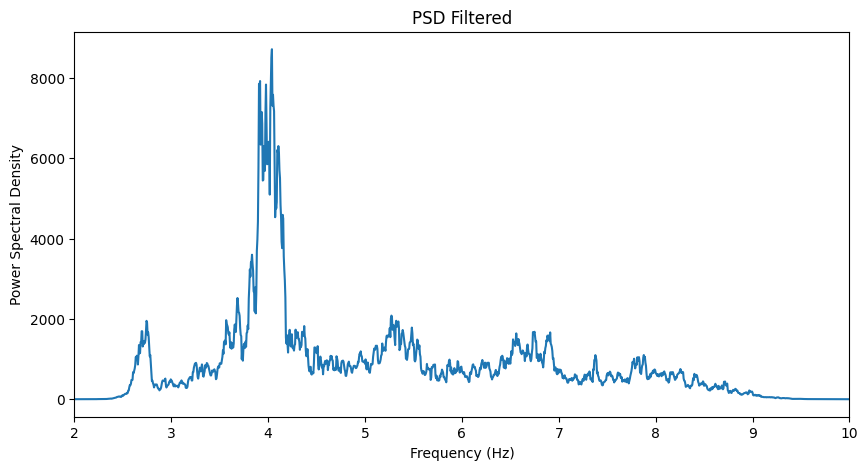

In [18]:
xlimit = freq_bands['theta']
xlimit = (xlimit[0]-2, xlimit[1]+2)
plt.figure(figsize=(10, 5))
plt.plot(freqs_filtered, psd_filtered.mean(0))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title(f"PSD Filtered")
plt.xlim(xlimit)
plt.show()